# Água Rasa 2D
Test

Computation scen1 done!
Courant number 0.19
Phase velocity (c): 38.35


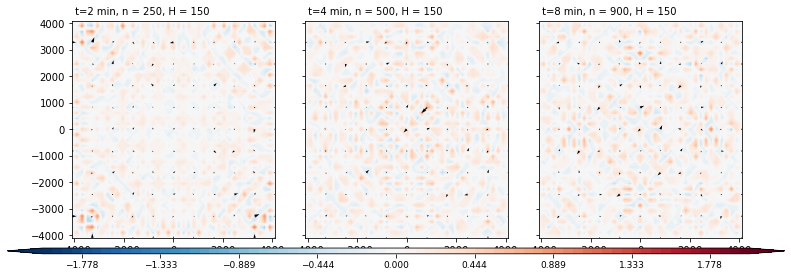

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
from functions import *
import os

# Physics parameters --------------------------------
g = 9.80665         # Gravity acceleration [m/s^2]
H = 150               # Height of the fluid [m]
c = np.sqrt(g*H)

# Conditions
Nx, Ny, dx, dy, Nt, dt, lat, Nrx, Nry  = 40, 40, 100, 100, 1000, 0.5, -20, 1, 1
"""
scen1: f=0
scen2: f at -20 degrees as lat
scen3: beta variation between -4000 to 4000
"""
cen = 'scen1'
arrow = 0.001

if c*dt/dx <= 0.35: 
    scen, x, y, X, Y, u, v, h, Fu, f, beta, div, vor = conditions(cen, lat, Nx, Ny, dx, dy, Nt, Nrx, Nry)
    
    u, v, h, div, vor = leapfrog(scen, Nx, Ny, Nt, u, v, h, g, dx, dy, dt, H, Fu, f, beta, y, c, div, vor)
    
    t_0 = time.perf_counter()  # For timing the computation loop
    print("Computation " + cen + " done!")
else:
    print("Oops! CFL > 0.35. Reduce dt or increase dx, dy")

print("Courant number {:.2f}".format(c*dt/dx))
print("Phase velocity (c): {:.2f}".format(c))

# Arrows
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

lvs = list(np.linspace(-2,2,6*12+1))
n = 1000
titles = ['f = 0', 'f em -20°S', 'Beta equatorial']
    
fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, n in zip(axes.flatten(), [250, 500, 900]):
    im = ax.contourf(X, Y, h[n,:,:], cmap=plt.cm.RdBu_r, levels=lvs, extend='both') 
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
        units = "xy", scale = arrow)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title(" t={:.0f} min, n = {:.0f}, H = {:.0f}".format(dt*n/60, n, H), fontsize=10, loc='left')
cax = fig.add_axes([.05,.07,0.9,.02]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
cbar.ax.tick_params(labelsize=9)

# animation
filenames = []
# plot the line chart

for n in range(1,Nt,2):
    fig, ax = plt.subplots()
    im = ax.contourf(X, Y, h[n,:,:], cmap=plt.cm.RdBu_r, levels=lvs, extend='both')
    fig.colorbar(im, ax=ax, orientation="vertical")
    ax.set_title("t={:.0f} min, passo de tempo = {:.0f}".format(dt*n/60, n), fontsize=10, loc='left')
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
                  units = "xy", scale = arrow)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=200)
    plt.close() # build gif

with imageio.get_writer('gifs/leap_teste_rig_'+str(H)+'m_'+scen+'.gif', mode='I', duration = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  

Radiational with Fu negative from east

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
from functions import *
import os

# Physics parameters --------------------------------
g = 9.80665         # Gravity acceleration [m/s^2]
H = 250               # Height of the fluid [m]
c = np.sqrt(g*H)

# Three scenarios
data = {}

# Conditions
Nx, Ny, dx, dy, Nt, dt, lat, Nrx, Nry  = 40, 40, 100, 100, 2000, 0.25, -20, 10, 4
"""
scen1: f=0
scen2: f at -20 degrees as lat
scen3: beta variation between -4000 to 4000
"""
cenarios = ['scen1', 'scen2', 'scen3']

if c*dt/dx <= 1: 
    for cen in cenarios:
        data[cen] = {'u':{}, 'v':{}, 'h':{}, 'div':{}, 'vor':{}}
        
        scen, x, y, X, Y, u, v, h, Fu, f, beta, div, vor = conditions(cen, lat, Nx, Ny, dx, dy, Nt, Nrx, Nry)
        # Initial conditions for u, v, & h
        # --------------------------------
        u[0, :, :] = 0.
        v[0, :, :] = 0.
        h[0, :, :] = 0.
        
        u, v, h, div, vor = leapfrog(scen, Nx, Ny, Nt, u, v, h, g, dx, dy, dt, H, Fu, f, beta, y, c, div, vor)
        data[cen]['u']   = u
        data[cen]['v']   = v
        data[cen]['h']   = h
        data[cen]['div'] = div
        data[cen]['vor'] = vor
        
        t_0 = time.perf_counter()  # For timing the computation loop
        print("Computation " + cen + " done!")
else:
    print("Oops! CFL > 0.35. Reduce dt or increase dx, dy")

print("Courant number {:.2f}".format(c*dt/dx))
print("Phase velocity (c): {:.2f}".format(c))


Computation scen1 done!
Computation scen2 done!
Computation scen3 done!
Courant number 0.12
Phase velocity (c): 49.51


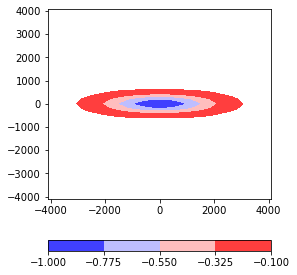

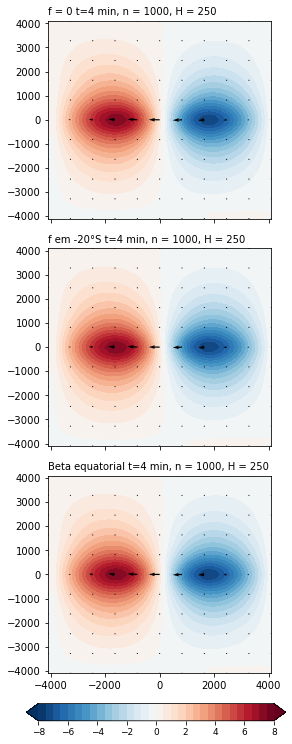

In [5]:
# Plots Zonal Source Wind--------------------------------------------------------
fig, ax = plt.subplots(figsize=(4,5))
im = ax.contourf(X, Y, Fu[0,:,:], cmap='bwr',levels=list(np.linspace(-1,-.1,5)))
fig.colorbar(im, ax=ax, orientation='horizontal') # pad, shrink
fig.savefig("fig/fonte_u.png", dpi = 300, bbox_inches='tight', facecolor='w')
# -------------------------------------------------------------------------------

# Arrows
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

lvs = list(np.linspace(-8,8,16*2+1))
n = 1000
titles = ['f = 0', 'f em -20°S', 'Beta equatorial']
    
fig, axes = plt.subplots(3,1, figsize=(4,12), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, scen, tit in zip(axes.flatten(), cenarios, titles):
    im = ax.contourf(X, Y, data[scen]['h'][n,:,:], cmap=plt.cm.RdBu_r, levels=lvs, extend='both')
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    u, v = data[scen]['u'], data[scen]['v']
    staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
        units = "xy", scale = 0.5)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title(tit+" t={:.0f} min, n = {:.0f}, H = {:.0f}".format(dt*n/60, n, H), fontsize=10, loc='left')
cax = fig.add_axes([.05,.07,0.9,.02]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
cbar.ax.tick_params(labelsize=9)
fig.savefig("fig/leapfrog_"+str(H)+"m_cenarios.png", dpi = 300, bbox_inches='tight', facecolor='w')


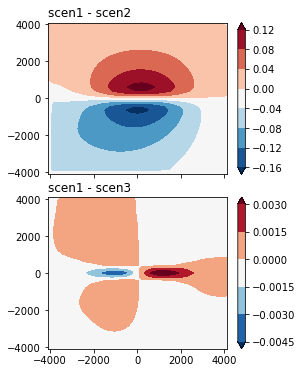

In [6]:
n = 1000
fig, axes = plt.subplots(2,1, figsize=(4,6), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, scen in zip(axes.flatten(), ['scen2', 'scen3']):
    im = ax.contourf(X, Y, data['scen1']['h'][n,:,:] - data[scen]['h'][n,:,:], cmap=plt.cm.RdBu_r, extend='both')
    cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    ax.set_title('scen1 - '+scen, loc='left')
fig.savefig("fig/leapfrog_"+str(H)+"m_dif.png", dpi = 300, bbox_inches='tight', facecolor='w')


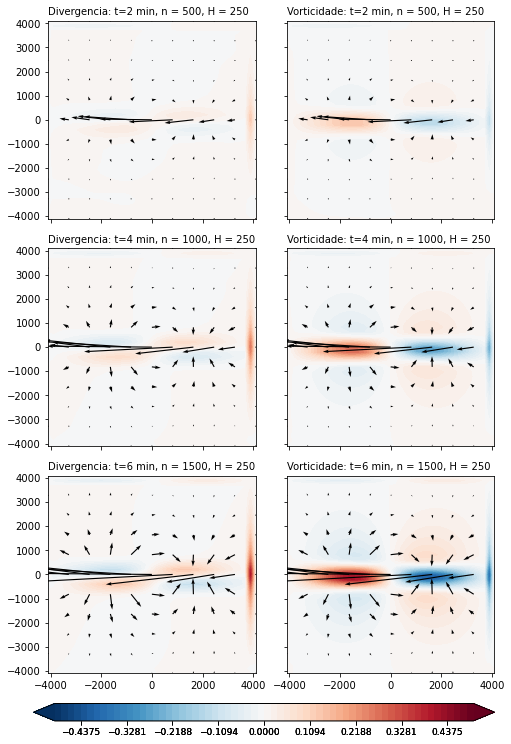

In [10]:
# Divergence & Vorticity
# ----------------------
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

lvs = list(np.linspace(-.5,.5,2*32+1))
enes = [500, 1000, 1500]
titles = ['f = 0', 'f em -20°S', 'Beta equatorial']
scen = 'scen3'
    
fig, axes = plt.subplots(3,2, figsize=(8,12), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
# Divergencia
# -----------
for ax, n in zip([axes[0,0], axes[1,0], axes[2,0]], enes):
    im = ax.contourf(X, Y, data[scen]['div'][n,:,:], cmap=plt.cm.RdBu_r, levels=lvs, extend='both')
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    u, v = data[scen]['u'], data[scen]['v']
    staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
        units = "xy", scale = 0.05)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title("Divergencia: t={:.0f} min, n = {:.0f}, H = {:.0f}".format(dt*n/60, n, H), fontsize=10, loc='left')
    cax = fig.add_axes([.1,.07,0.8,.02]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
    cbar.ax.tick_params(labelsize=9)
    
# Vorticidade
# -----------
for ax, n in zip([axes[0,1], axes[1,1], axes[2,1]], enes):
    im = ax.contourf(X, Y, data[scen]['vor'][n,:,:], cmap=plt.cm.RdBu_r, levels=lvs, extend='both')
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    u, v = data[scen]['u'], data[scen]['v']
    staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
        units = "xy", scale = 0.05)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title("Vorticidade: t={:.0f} min, n = {:.0f}, H = {:.0f}".format(dt*n/60, n, H), fontsize=10, loc='left')

fig.savefig("fig/leapfrog_div_vor"+str(H)+"m_"+scen+".png", dpi = 300, bbox_inches='tight', facecolor='w')


In [14]:
filenames = []
# plot the line chart
scen ='scen3'
lvs = list(np.linspace(-8,8,16*2+1))

for n in range(1,Nt,2):
    fig, ax = plt.subplots()
    im = ax.contourf(X, Y, data[scen]['h'][n,:,:], cmap=plt.cm.RdBu_r, levels=lvs,extend='both')
    fig.colorbar(im, ax=ax, orientation="vertical")
    ax.set_title("t={:.0f} min, passo de tempo = {:.0f}".format(dt*n/60, n), fontsize=10, loc='left')
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
                  units = "xy", scale = 0.1)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=200)
    plt.close() # build gif

with imageio.get_writer('gifs/leap_'+str(H)+'m_'+scen+'.gif', mode='I', duration = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  